# GPX Data

I am fortunate to live in New Mexico where I can take beautiful and varied walks, hikes and bike rides nearly every day, which I do. I have been working with GIS data lately, and it crossed my mind that, since I record most of my excursions with an app on my phone, there must be lots of data that I can play with to do mapping and analysis. I was pleased to discover that the simple app I use on my phone to track my excursions can easily export the data to GPX format. I had no idea what GPX format was, but assumed it was some standard, so things looked promising. 

In this article, I will show how I used Python to convert the GPX data to a geopandas GeoDataFrame, from which I can create maps and generate statistical information about the trek. 

In [2]:
import pandas as pd 
import geopandas as gpd 
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from shapely import LineString

In [3]:
import matplotlib as mpl 
mpl.rc(
    'lines', 
    linewidth=2, markersize=4
) 
mpl.rc('figure', figsize=(10,10), titlesize='large', titleweight='bold')

In [4]:
trek_df = pd.read_csv('data/b3/Workout-2024-09-05-15-25-13.csv')

In [5]:
trek_df.iloc[0]

Id         Workout-2024-09-05-15-25-13
Name                        Park Ridge
Lat                          41.043858
Lon                         -74.063712
Elev                                79
Time          2024-09-05T15:25:13.004Z
Temp                             20.51
Weather                              0
Name: 0, dtype: object

In [6]:
trek_gdf = gpd.GeoDataFrame( 
    trek_df, 
    geometry=gpd.points_from_xy(x=trek_df.Lon, y=trek_df.Lat)
).set_crs(4269)

In [7]:
trek_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Id        650 non-null    object  
 1   Name      650 non-null    object  
 2   Lat       650 non-null    float64 
 3   Lon       650 non-null    float64 
 4   Elev      650 non-null    int64   
 5   Time      650 non-null    object  
 6   Temp      650 non-null    float64 
 7   Weather   650 non-null    int64   
 8   geometry  650 non-null    geometry
dtypes: float64(3), geometry(1), int64(2), object(3)
memory usage: 45.8+ KB


In [8]:
trek_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [9]:
trek_gdf['Time'] = pd.to_datetime(trek_gdf.Time)

In [10]:
trek_gdf.Time[0].strftime('%B %d, %Y')

'September 05, 2024'

In [11]:
trek_gdf.Time[0].strftime('%c')

'Thu Sep  5 15:25:13 2024'

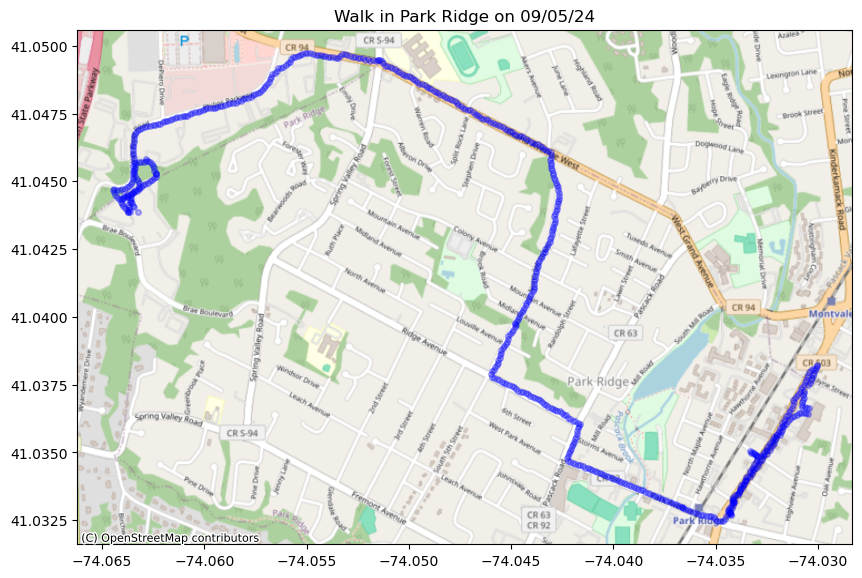

In [12]:
f, ax = plt.subplots()
trek_gdf.plot(ax=ax, alpha=0.3, c='b')
plt.title(f'Walk in {trek_gdf.Name[0]} on {trek_gdf.Time[0].strftime('%x')}')
ctx.add_basemap(ax, crs=trek_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik);

In [13]:
trek_proj = trek_gdf.copy().to_crs(32111)

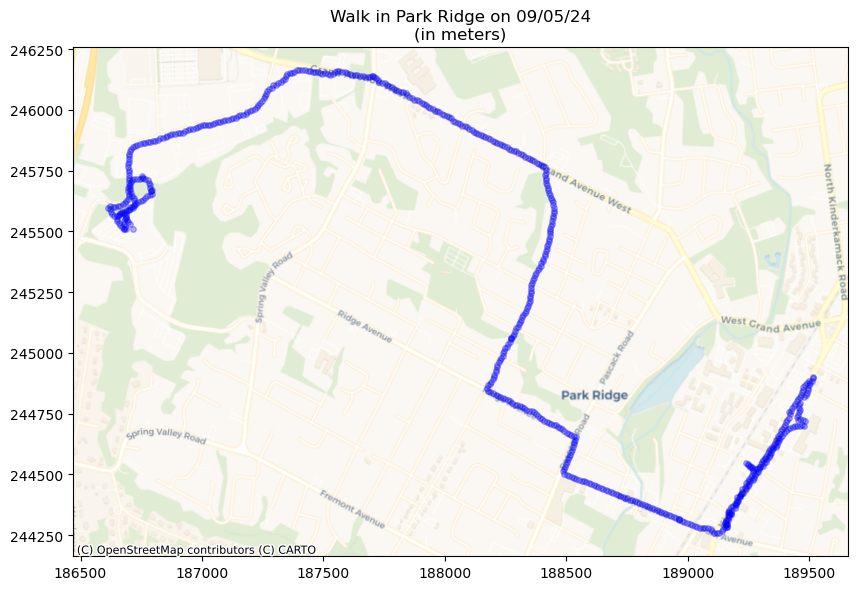

In [14]:
f, ax = plt.subplots()
trek_proj.plot(ax=ax, alpha=0.3, c='b') 
plt.title(f'Walk in {trek_gdf.Name[0]} on {trek_gdf.Time[0].strftime('%x')}\n(in meters)')
ctx.add_basemap(ax, crs=trek_proj.crs, source=ctx.providers.CartoDB.Voyager);

In [15]:
trek_proj.describe()

,Lat,Lon,Elev,Temp,Weather
count,650.000000,650.000000,650.000000,650.00,650.0
mean,41.041222,-74.046110,45.143077,20.51,0.0
std,0.005818,0.011167,20.266092,0.00,0.0
min,41.032476,-74.064483,11.000000,20.51,0.0
25%,41.035545,-74.056430,24.000000,20.51,0.0
50%,41.042023,-74.044050,49.500000,20.51,0.0
75%,41.046799,-74.035237,63.000000,20.51,0.0
max,41.049728,-74.030031,81.000000,20.51,0.0


In [18]:
#trek_proj.drop(columns=['TimeS'], inplace=True)

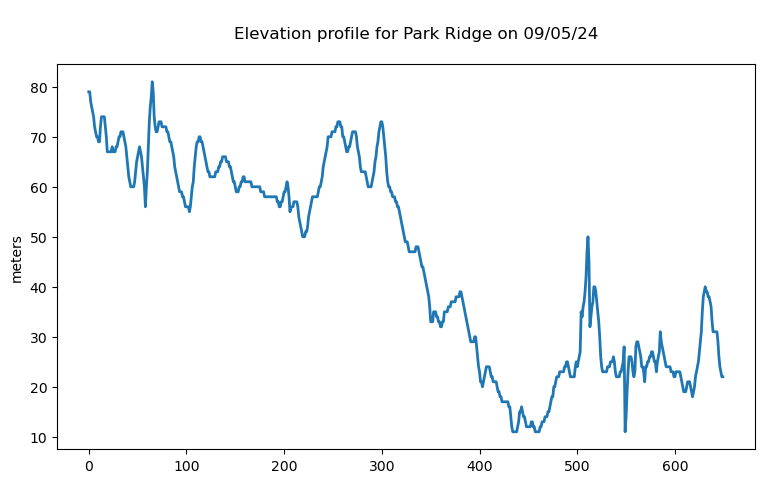

In [19]:
f, ax = plt.subplots(figsize=(9,5))
ax = trek_proj.Elev.plot()
ax.set_title(f'''
    Elevation profile for {trek_gdf.Name[0]} on {trek_gdf.Time[0].strftime('%x')}
    ''')
ax.set_ylabel('meters');

In [79]:
trek_proj['Point'] = trek_proj.index

In [121]:
sns.set_theme()

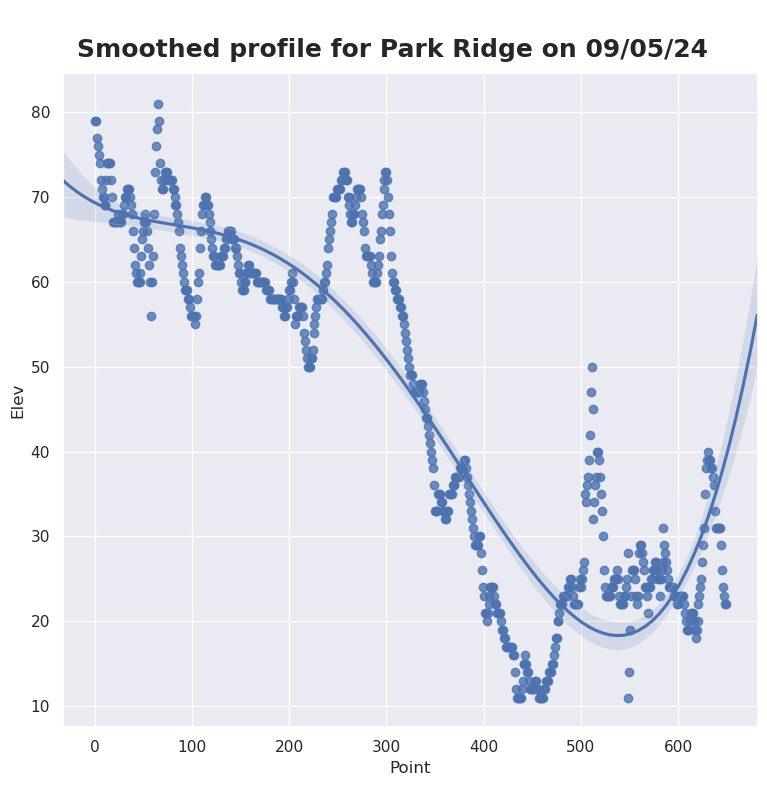

In [122]:
# f, ax = plt.subplots(figsize=(9,9))
plot = sns.lmplot(data=trek_proj, x='Point', y='Elev', 
           order=4, truncate=False, height=8, aspect=1)
plot.figure.subplots_adjust(top=0.9, left=.11)
plot.fig.suptitle(f'''
    Smoothed profile for {trek_gdf.Name[0]} on {trek_gdf.Time[0].strftime('%x')}
    ''', fontsize=18);

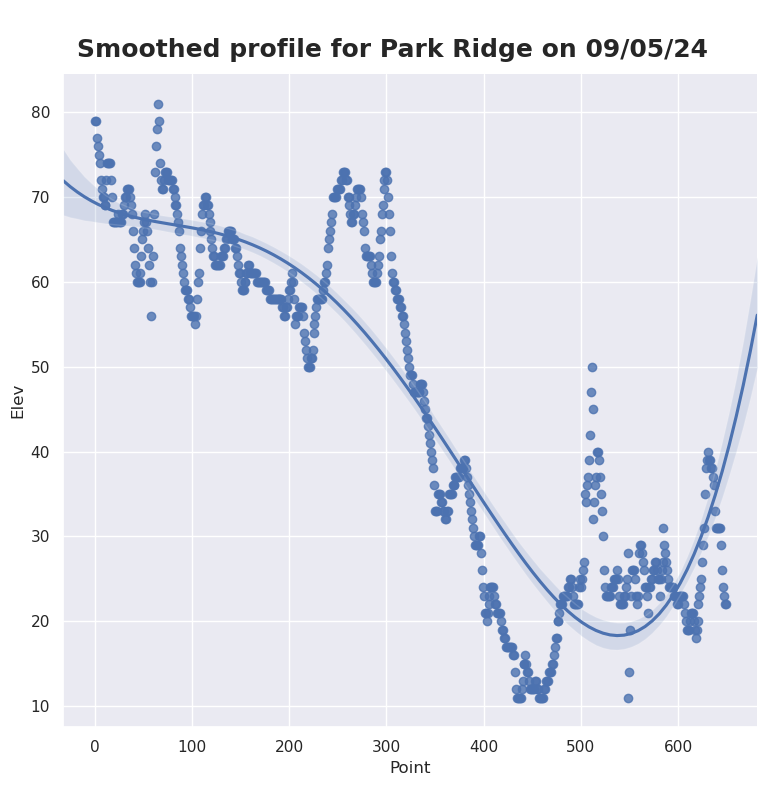

In [123]:
sns.set_theme(rc={'figure.figsize':(6,6)})
plot = sns.lmplot(data=trek_proj, x='Point', y='Elev', 
                  order=4, truncate=False, height=8, aspect=1)
plot.figure.subplots_adjust(top=0.9, left=.11)
plot.fig.suptitle(f'''
    Smoothed profile for {trek_gdf.Name[0]} on {trek_gdf.Time[0].strftime('%x')}
    ''', fontsize=18);

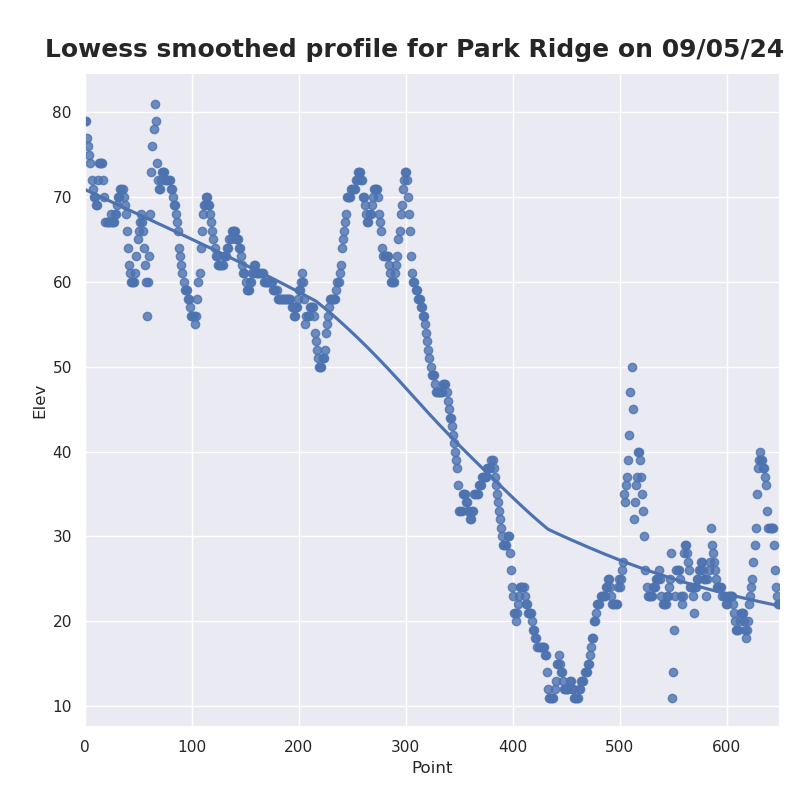

In [124]:
sns.set_theme(rc={'figure.figsize':(6,6)})
plot = sns.lmplot(data=trek_proj, x='Point', y='Elev', 
                  lowess=True, truncate=False, height=8, aspect=1)
plot.figure.subplots_adjust(top=0.9, left=.11)
plot.fig.suptitle(f'''
    Lowess smoothed profile for {trek_gdf.Name[0]} on {trek_gdf.Time[0].strftime('%x')}
    ''', fontsize=18);

In [125]:
trek_proj['ElevDiff'] = [trek_proj.iloc[i].Elev - trek_proj.iloc[i-1].Elev for i in range(len(trek_proj))]
trek_proj.loc[0, 'ElevDiff'] = 0

In [126]:
line = LineString(trek_proj.geometry)
print(f'''
    The {trek_proj.iloc[0].Name} walk was {line.length / 1000:.1f} kilometers
    
    Elevations: 
        Initial:       {trek_proj.iloc[0].Elev:>3} meters 
        Final:         {trek_proj.iloc[-1].Elev:>3} meters 
        Highest:       {trek_proj.Elev.max():>3} meters 
        Lowest:        {trek_proj.Elev.min():>3} meters 
        Total ascent:  {trek_proj[trek_proj.ElevDiff > 0].ElevDiff.sum():>3} meters
        Total descemt: {-trek_proj[trek_proj.ElevDiff < 0].ElevDiff.sum():>3} meters
''')


    The Park Ridge walk was 7.0 kilometers
    
    Elevations: 
        Initial:        79 meters 
        Final:          22 meters 
        Highest:        81 meters 
        Lowest:         11 meters 
        Total ascent:  257 meters
        Total descemt: 314 meters



In [127]:
trek_gdf.to_file('data/trek.gpkg', driver='GPKG')
trek_proj.to_file('data/trek_proj.gpkg', driver='GPKG')